### Finding Exact Solutions and Classical Hardness of Finding MIS

We use this file to use the bloqade subspace function and tensor network methods to compute exact solutions to MIS graphs. We find all possible MISs and use the information to calculate the probability of obtaining a MIS when we run quantum algorithms in the python file. 

import Pkg; Pkg.add("GenericTensorNetworks")

In [2]:
using Bloqade
using Random
using PythonCall
using Printf

plt = pyimport("matplotlib.pyplot");

As an example, we generate a 8x8 square lattice of blockade radius $3.08 a$, where $a$ is the lattice constant. We calculate 3.08 from the desired $R_\text{min} = 3$ and the radius including the next nearest neighbors.  

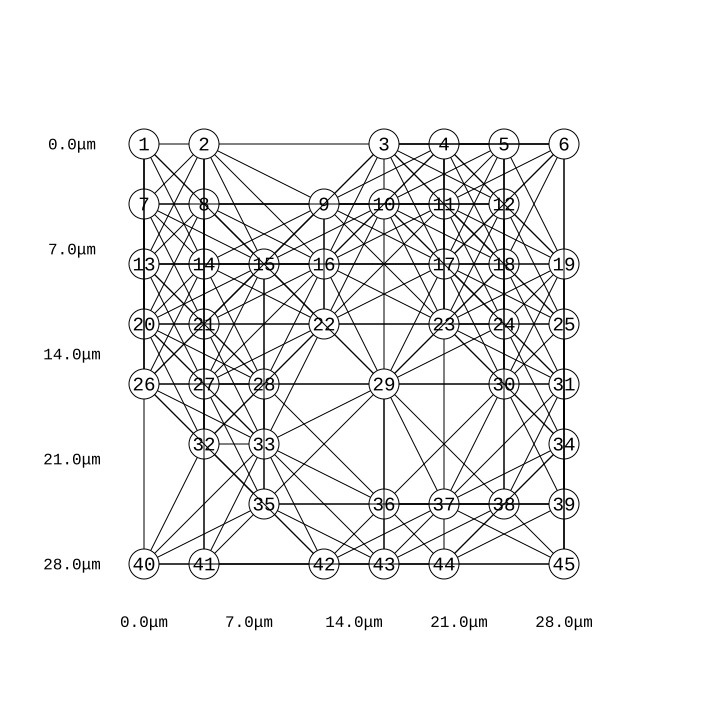

In [5]:
blk_rad=3.08*4
atoms = generate_sites(SquareLattice(), 8, 8; scale = 4) |> random_dropout(0.3)
Bloqade.plot(atoms, blockade_radius=blk_rad)

We use blockade subspace to filter out all non-independent sets, and then only keep the states with the maximum number of excited atoms. In the example below, we see that the number of MIS states is 17, while the number of total independent sets is 43249. 

In [6]:
space = blockade_subspace(atoms, blk_rad)

baseten = collect(keys(space))
@printf "Number of Independent Sets: %d\n" (length(baseten))
max_ones = 0
# for item in baseten
#     println(bitstring(item)[end-length(atoms)+1:end])
# end
for item in baseten
    ones = count_zeros(~item)
    max_ones = max(ones, max_ones)
end
mis_size = max_ones
bool = zeros(Bool, size(baseten))
for (i, item) in enumerate(baseten)
    if count_zeros(~item) == max_ones
        bool[i] = 1
    end
end
baseten = baseten[bool]
@printf "Number of MIS: %d\n" (length(baseten))
println("MIS List:")
for item in baseten
    println(bitstring(item)[end-length(atoms)+1:end])
end

Number of Independent Sets: 43249
Number of MIS: 17
MIS List:
100010000000000010011000000000000000100010001
100100000000000010011000000000000000100010001
100010000100000000010100000000000000100100001
100010000100000000010100000001000000000100001
100010000100000000011001000000000000000001010
100001000100000000100100000000000000100100001
100010000100000000010001001000000000000000101
100001000100000000101000000000000000100010001
001001100000000000100100000000000000100100001
100010000100000000011001000000000000000001001
001001100000000001000100000000000000100100001
100010000100000000011000000001000000000010001
100010000100000000011001000000000000000010001
100010000100000000011001000000000000000000101
100010000100000000011000000000000000100010001
100010000100000000011001000000000000000010010
010010000000000010011000000000000000100010001


Using tensor network methods to compute the degeneracy of MIS states, we can compute the classical hardness of the MIS finding algorithm. The tensor network method can also attain the same solution, at least for relatively small graphs. 

In [7]:
graph = BloqadeMIS.unit_disk_graph(atoms,blk_rad)
using GenericTensorNetworks
problem = IndependentSet(graph; optimizer=TreeSA())
count_max2_independent_sets = GenericTensorNetworks.solve(problem, CountingMax(2))[]
hardness = count_max2_independent_sets.coeffs[1]/(count_max2_independent_sets.coeffs[2] * mis_size)

5.6838235294117645

In [8]:
all_max_configs = GenericTensorNetworks.solve(problem, ConfigsMax(; bounded=false))[]

(8.0, {101000000000000000100100010000000001000010001, 100010000000000000000100110000000001000010001, 100100000000000000000100110000000001000010001, 010010000000000000000100110000000001000010001, 010100000000000000000100110000000001000010001, 101000000000000000000100110000000001000010001, 100010001000000000000000110000000001000010001, 100010001000000000000000101000000001000100001, 100010000000000100000000110000000001000010001, 100010001000000000000000110010000000000010001, 100010001000000000000000110010000000000010010, 100010001000000000000000110010000000000001001, 100001001000000000000001001000000000001100100, 100001001000000000000001000100000000001100100, 100001001000000000000001010000000001000010001, 100001001000000000000001001000000001000100001, 100001000000000100000001010000000001000010001})ₜ